Automatic parameter estimation for GR4J. Uses scipy optimize packages.

Following exemples found in https://stackoverflow.com/questions/19664865/migrating-from-pulp-to-scipy

Preparing the functions

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.optimize as opt

# GR4J lives in a directory above this code. Not sure this is the best practice...
import os, sys
sys.path.append(os.path.relpath("../gr4j"))
from gr4j import gr4j

# discharge conversion functions
def m3_to_mm(q, area):
    '''Convert m3/s discharge data to mm/day
    q: list of daily discharge records
    area: basin area (km2)
    return: list of converted discharge records
    '''
    return [i * 86.4 / area for i in q]


# Objective function (Nash-Sutcliffe)
def nash(qobs, qsim):
    top = sum((qsim - qobs)**2)
    bottom = sum((qobs.mean() - qobs)**2)
    return 1 - top/bottom

# function to be minimized
def fun(guess, prec, etp, qobs):
    params = {'X1': guess[0],
              'X2': guess[1],
              'X3': guess[2],
              'X4': guess[3]
             }
    
    states = {'production_store': 0.60 * params['X1'],
              'routing_store': 0.70 * params['X3']
             }

    qsim = gr4j(prec, etp, params, states)
    n = nash(qobs, qsim)
    return -n


Testing the automatic parameter estimation using the dataset that comes with the GR4J_en.xlsx model spreadsheet. This data is from _Le Léguer à Belle-Isle-en-Terre_ watershed. The original model was obtained from https://webgr.irstea.fr/en/modeles/journalier-gr4j-2/fonctionnement_gr4j/.

A more detailed description of the dataset can be found on the dataset directory of this repository.


In [3]:
# Reading sample data that comes with the original model - french basin
test_data = pd.read_csv('datasets/gr4j_test_data.csv')
test_data['Date'] = pd.to_datetime(test_data['Date'])
test_data = test_data.set_index('Date')

# Initial guess of model parameters
# done as a list since it's what the optimization function expects.
# GR4J funcion recieves a dictionary
# This is treated inside the funcion to be optmized. 
#guess = [320.11, 2.42, 69.63, 1.39]
guess = [300, 3, 50, 2]

# Calibrating model with the first year of data
prec_cal = test_data['Precip (mm)'].loc[:'1991-12-31']
etp_cal = test_data['ETP (mm)'].loc[:'1991-12-31']
qobs_cal = test_data['Qobs (mm/day)'].loc[:'1991-12-31']
qsim_orig_cal = test_data['Qsim (mm/day)'].loc[:'1991-12-31']

result = opt.minimize(fun, guess, method='SLSQP', args=(prec_cal, etp_cal, qobs_cal))
#result = opt.minimize(fun, guess, method='Nelder-Mead', args=(prec_cal, etp_cal, qobs_cal))

# Simulating using the optimized parameters

params = {'X1': result['x'][0],
          'X2': result['x'][1],
          'X3': result['x'][2],
          'X4': result['x'][3]
         }

states = {'production_store': 0.60 * params['X1'],
          'routing_store': 0.70 * params['X3']
         }

# Running for the entire period but verifying for the seccond year
prec = test_data['Precip (mm)']
etp = test_data['ETP (mm)']
qobs = test_data['Qobs (mm/day)']
qsim_orig = test_data['Qsim (mm/day)']

qsim = gr4j(prec, etp, params, states)
qsim = pd.DataFrame(qsim, columns = ['qsim_mod'], index = pd.date_range('1991-1-1', '1992-12-30'))

data = pd.concat([test_data, qsim], axis=1)

# checking the adjustment (Nash-Sutcliffe)
print("Nash coefficient obtained in the spreadsheet was 0.919")
print("Nash coefficient obtained here is: {:.3f}".format(nash(
    data['Qobs (mm/day)'].loc['1992-1-1':],
    data['qsim_mod'].loc['1992-1-1':])))

Nash coefficient obtained in the spreadsheet was 0.919
Nash coefficient obtained here is: 0.760


In [4]:
print('Model parameters in the spreadsheet were:')
print('X1: 320.107; X2: 2.421; X3: 69.628; X4: 1.389')
print('Model parameters obtained here are:')
print('X1: {:.3f}; X2: {:.3f}; X3: {:.3f}; X4: {:.3f}'
     .format(result.x[0], result.x[1],
             result.x[2], result.x[3]))

Model parameters in the spreadsheet were:
X1: 320.107; X2: 2.421; X3: 69.628; X4: 1.389
Model parameters obtained here are:
X1: 360.643; X2: 1.617; X3: 146.031; X4: 1.063


In [5]:
# running the model with the parameters from the excell spreadsheet exemple
params_ex = {'X1': 320.107,
          'X2': 2.421,
          'X3': 69.628,
          'X4': 1.389
         }

states_ex = {'production_store': 0.60 * params['X1'],
          'routing_store': 0.70 * params['X3']
         }

qsim_ex = gr4j(prec, etp, params_ex, states_ex)

print('Running the model with the original parameters')
print('Nash coefficient equals to the one from the spreadsheet')
print('Nash: {:.3f}'.format(nash(
    data['Qobs (mm/day)'].loc['1992-1-1':],
    qsim_ex[365:])))

Running the model with the original parameters
Nash coefficient equals to the one from the spreadsheet
Nash: 0.919


What we've seen is that the python optimization can find some good parameters for the model. However, parameters obtained using the solver routines from excell yielded better results. Some things to evaluate:
1. What optimization algorithm does Excell solver utilizes?
  * For nonlinear optimization: Generalized Reduced Gradient (GRG2)
  * Linear programming: Simplex and dual Simplex from Simplex LP
  * non-smooth optimization: various genetic algorithms
  * source: https://www.solver.com/excel-solver-algorithms-and-methods-used
2. The excell spreadsheed optimizes a transformed coefficient. Check if that changes something
  * The documentation in the R package about adding other optimization methods mentions that we should used transformed parameters, to ensure homogenity of displacement in different dimensions of the parameter space
  * https://cran.r-project.org/web/packages/airGR/vignettes/V02.1_param_optim.html
3. Change options in the python solver
4. Deppending on the solver and on the initial guess, the optimizatin does not work and I get a "IndexError: list index out of range". Ex.: guess = [400, 3, 50, 2]; solver = SLSQP

Some observations with solver = SLSQP:

| Guess parameters   | Nash |
|--------------------|------|
| [303, 3.2, 65, 1]  | 0.768|
| [303, 3.2, 50, 0.5]| 0.728| 
|[320, 2.4, 70, 1.4] | 0.766|
|[320.11, 2.42, 69.63, 1.39]| 0.766|

Even using the initial guess very close to the results from the Excell spreadsheet, I cannot get a Nash coefficient close to 0.92! Need to investigate solver options a bit more.

Anyway, plotting some figures:


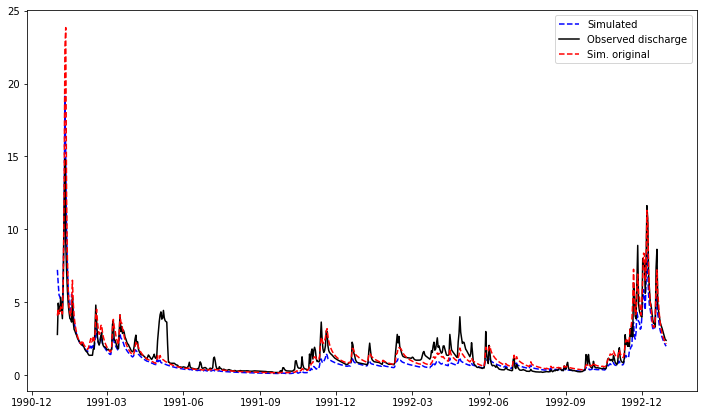

In [6]:
plt.figure(figsize=(12,7))

plt.plot(data['qsim_mod'], 'b--', label = 'Simulated')
plt.plot(data['Qobs (mm/day)'], 'k', label = 'Observed discharge')
plt.plot(data['Qsim (mm/day)'], 'r--', label = 'Sim. original')
plt.legend()

plt.show()